<a href="https://colab.research.google.com/github/artkpv/dl_4_cv_umich/blob/main/assignment3/fully_connected_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# EECS 498-007/598-005 Assignment 3-1: Fully-Connected Neural Networks and Dropout



Author: Artem Karpov, artkpv dot net

# Fully-connected neural networks
In the previous homework you implemented a fully-connected two-layer neural network on CIFAR-10. The implementation was simple but not very modular since the loss and gradient were computed in a single monolithic function. This is manageable for a simple two-layer network, but would become impractical as we move to bigger models. Ideally we want to build networks using a more modular design so that we can implement different layer types in isolation and then snap them together into models with different architectures.

In this exercise we will implement fully-connected networks using a more modular approach. For each layer we will implement a `forward` and a `backward` function. The `forward` function will receive inputs, weights, and other parameters and will return both an output and a `cache` object storing data needed for the backward pass, like this:

```python
def forward(x, w):
  """ Receive inputs x and weights w """
  # Do some computations ...
  z = # ... some intermediate value
  # Do some more computations ...
  out = # the output
   
  cache = (x, w, z, out) # Values we need to compute gradients
   
  return out, cache
```

The backward pass will receive upstream derivatives and the `cache` object, and will return gradients with respect to the inputs and weights, like this:

```python
def backward(dout, cache):
  """
  Receive dout (derivative of loss with respect to outputs) and cache,
  and compute derivative with respect to inputs.
  """
  # Unpack cache values
  x, w, z, out = cache
  
  # Use values in cache to compute derivatives
  dx = # Derivative of loss with respect to x
  dw = # Derivative of loss with respect to w
  
  return dx, dw
```

After implementing a bunch of layers this way, we will be able to easily combine them to build classifiers with different architectures.

In addition to implementing fully-connected networks of arbitrary depth, we will also explore different update rules for optimization, and introduce Dropout as a regularizer as a tool to more efficiently optimize deep networks.
  

## Install starter code
We will continue using the utility functions that we've used for Assignment 1 and 2: [`coutils` package](https://github.com/deepvision-class/starter-code). Run this cell to download and install it.


In [1]:
!pip install git+https://github.com/deepvision-class/starter-code

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/deepvision-class/starter-code to /tmp/pip-req-build-m833zs4g
  Running command git clone -q https://github.com/deepvision-class/starter-code /tmp/pip-req-build-m833zs4g
  Created wheel for Colab-Utils: filename=Colab_Utils-0.1.dev0-py3-none-any.whl size=10306 sha256=4890bb4263f657265425b0e5eea4d997efb091e653cd6b9e61ac897a67ed5d0b
  Stored in directory: /tmp/pip-ephem-wheel-cache-6pv1z1ce/wheels/eb/3c/88/465b0d78ef4a63d1f487c4208bd4691a448f05923eda0ef5f6
Successfully built Colab-Utils


## Setup code
Run some setup code for this notebook: Import some useful packages and increase the default figure size.

In [2]:
import math
import torch
import coutils
from coutils import fix_random_seed, rel_error, compute_numeric_gradient, Solver
import matplotlib.pyplot as plt

# for plotting
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# data type and device for torch.tensor
to_float = {'dtype': torch.float, 'device': 'cpu'}
to_float_cuda = {'dtype': torch.float, 'device': 'cuda'}
to_double = {'dtype': torch.double, 'device': 'cpu'}
to_double_cuda = {'dtype': torch.double, 'device': 'cuda'}
to_long = {'dtype': torch.long, 'device': 'cpu'}
to_long_cuda = {'dtype': torch.long, 'device': 'cuda'}

## Load CIFAR-10 data
Here we provide a function to load up our favorite CIFAR-10 data so we can use it to train a classifier on a real dataset.

In [3]:
def get_CIFAR10_data(validation_ratio=0.05, cuda=False, reshape_to_2d=False,
                     visualize=False):
  """
  Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
  it for the linear classifier. These are the same steps as we used for the
  SVM, but condensed to a single function.  
  """
  X_train, y_train, X_test, y_test = coutils.data.cifar10()

  # Load every data on cuda
  if cuda:
    X_train = X_train.cuda()
    y_train = y_train.cuda()
    X_test = X_test.cuda()
    y_test = y_test.cuda()

  # 0. Visualize some examples from the dataset.
  class_names = [
      'plane', 'car', 'bird', 'cat', 'deer',
      'dog', 'frog', 'horse', 'ship', 'truck'
  ]
  if visualize:
    img = coutils.utils.visualize_dataset(X_train, y_train, 12, class_names)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

  # 1. Normalize the data: subtract the mean RGB (zero mean)
  mean_image = X_train.mean(dim=0, keepdim=True).mean(dim=2, keepdim=True).mean(dim=3, keepdim=True)
  X_train -= mean_image
  X_test -= mean_image

  # 2. Reshape the image data into rows
  if reshape_to_2d:
    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)

  # 3. Take the validation set from the training set
  # Note: It should not be taken from the test set
  # For random permumation, you can use torch.randperm or torch.randint
  # But, for this homework, we use slicing instead.
  num_training = int( X_train.shape[0] * (1.0 - validation_ratio) )
  num_validation = X_train.shape[0] - num_training

  # return the dataset
  data_dict = {}
  data_dict['X_val'] = X_train[num_training:num_training + num_validation]
  data_dict['y_val'] = y_train[num_training:num_training + num_validation]
  data_dict['X_train'] = X_train[0:num_training]
  data_dict['y_train'] = y_train[0:num_training]

  data_dict['X_test'] = X_test
  data_dict['y_test'] = y_test
  return data_dict

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .


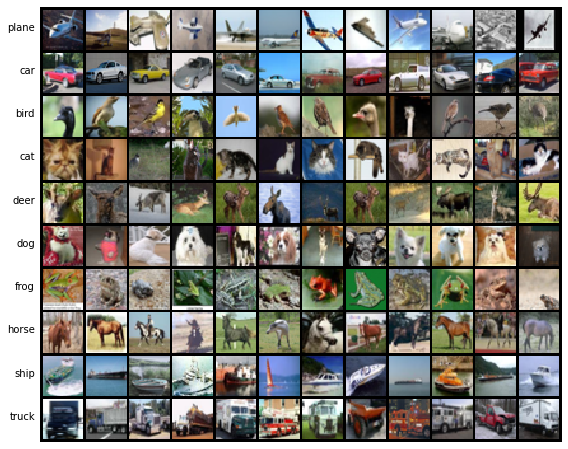

Train data shape:  torch.Size([47500, 3, 32, 32])
Train labels shape:  torch.Size([47500])
Validation data shape:  torch.Size([2500, 3, 32, 32])
Validation labels shape:  torch.Size([2500])
Test data shape:  torch.Size([10000, 3, 32, 32])
Test labels shape:  torch.Size([10000])


In [4]:
# Invoke the above function to get our data.
data_dict = get_CIFAR10_data(visualize=True)
print('Train data shape: ', data_dict['X_train'].shape)
print('Train labels shape: ', data_dict['y_train'].shape)
print('Validation data shape: ', data_dict['X_val'].shape)
print('Validation labels shape: ', data_dict['y_val'].shape)
print('Test data shape: ', data_dict['X_test'].shape)
print('Test labels shape: ', data_dict['y_test'].shape)

# Linear layer

For each layer we implement, we will define a class with two static methods `forward` and `backward`.

For now the `forward` and `backward` methods are stubs. We will actually implement them in the following cells.

In [5]:
class Linear(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## Linear layer: forward
Implement the `Linear.forward` function. Once you are done you can test your implementaion by running the next cell:

In [21]:
def linear_forward(x, w, b):
  """
  Computes the forward pass for an linear (fully-connected) layer.
  The input x has shape (N, d_1, ..., d_k) and contains a minibatch of N
  examples, where each example x[i] has shape (d_1, ..., d_k). We will
  reshape each input into a vector of dimension D = d_1 * ... * d_k, and
  then transform it to an output vector of dimension M.
  Inputs:
  - x: A tensor containing input data, of shape (N, d_1, ..., d_k)
  - w: A tensor of weights, of shape (D, M)
  - b: A tensor of biases, of shape (M,)
  Returns a tuple of:
  - out: output, of shape (N, M)
  - cache: (x, w, b)
  """
  out = None
  #############################################################################
  # TODO: Implement the linear forward pass. Store the result in out. You     #
  # will need to reshape the input into rows.                                 #
  #############################################################################
  # Replace "pass" statement with your code
  xx = x.reshape(x.shape[0], -1)
  out = xx @ w + b
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = (x, w, b)
  return out, cache

Linear.forward = linear_forward

Test the `Linear.forward` function. You should see errors less than `1e-8`.

In [22]:
# Test the Linear.forward function
num_inputs = 2
input_shape = torch.tensor((4, 5, 6))
output_dim = 3

input_size = num_inputs * torch.prod(input_shape)
weight_size = output_dim * torch.prod(input_shape)

x = torch.linspace(-0.1, 0.5, steps=input_size, **to_double_cuda).reshape(num_inputs, *input_shape)
w = torch.linspace(-0.2, 0.3, steps=weight_size, **to_double_cuda).reshape(torch.prod(input_shape), output_dim)
b = torch.linspace(-0.3, 0.1, steps=output_dim, **to_double_cuda)

out, _ = Linear.forward(x, w, b)
correct_out = torch.tensor([[ 1.49834967,  1.70660132,  1.91485297],
                            [ 3.25553199,  3.5141327,   3.77273342]],
                            **to_double_cuda)

print('Testing Linear.forward function:')
print('difference: ', rel_error(out, correct_out))

Testing Linear.forward function:
difference:  1.9539697795885023e-09


## Linear layer: backward
Now implement the `Linear.backward` function and test your implementation using numeric gradient checking.

In [27]:
def linear_backward(dout, cache):
  """
  Computes the backward pass for an linear layer.
  Inputs:
  - dout: Upstream derivative, of shape (N, M)
  - cache: Tuple of:
    - x: Input data, of shape (N, d_1, ... d_k)
    - w: Weights, of shape (D, M)
    - b: Biases, of shape (M,)
  Returns a tuple of:
  - dx: Gradient with respect to x, of shape (N, d1, ..., d_k)
  - dw: Gradient with respect to w, of shape (D, M)
  - db: Gradient with respect to b, of shape (M,)
  """
  x, w, b = cache
  dx, dw, db = None, None, None
  #############################################################################
  # TODO: Implement the linear backward pass.                                 #
  #############################################################################
  # Replace "pass" statement with your code
  N = x.shape[0]
  D, M = w.shape
  dx = dout @ w.T
  dx = dx.reshape(x.shape)
  dw = x.reshape(N, -1).T @ dout
  db = torch.diagonal(dout)
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx, dw, db

Linear.backward = linear_backward

Run the following to test your implementation of `Linear.backward`. You should see errors less than `1e-8`.

In [28]:
# Test the Linear.backward function
fix_random_seed(0)
x = torch.randn(10, 2, 3, **to_double_cuda)
w = torch.randn(6, 5, **to_double_cuda)
b = torch.randn(5, **to_double_cuda)
dout = torch.randn(10, 5, **to_double_cuda)

dx_num = compute_numeric_gradient(lambda x: Linear.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear.forward(x, w, b)[0], b, dout)

_, cache = Linear.forward(x, w, b)
dx, dw, db = Linear.backward(dout, cache)

# The error should be around e-10 or less
print('Testing Linear.backward function:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

Testing Linear.backward function:
dx error:  2.340771536181963e-09
dw error:  6.573349127694478e-11
db error:  93.53332629784174


# ReLU activation

We will now implement the ReLU nonlinearity. As above, we will define a class with two empty static methods, and implement them in upcoming cells.

In [ ]:
class ReLU(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## ReLU activation: forward
Implement the forward pass for the ReLU activation function in the `ReLU.forward` function.

You should not change the input tensor with an in-place operation.

In [ ]:
def relu_forward(x):
  """
  Computes the forward pass for a layer of rectified linear units (ReLUs).
  Input:
  - x: Input; a tensor of any shape
  Returns a tuple of:
  - out: Output, a tensor of the same shape as x
  - cache: x
  """
  out = None
  #############################################################################
  # TODO: Implement the ReLU forward pass.                                    #
  # You should not change the input tensor with an in-place operation.        #
  #############################################################################
  # Replace "pass" statement with your code
  pass
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  cache = x
  return out, cache

ReLU.forward = relu_forward

Run the following to test your implementation of the ReLU forward pass. Your errors should be less than `1e-7`.

In [ ]:
# Test the relu_forward function
x = torch.linspace(-0.5, 0.5, steps=12, **to_double_cuda).reshape(3, 4)

out, _ = ReLU.forward(x)
correct_out = torch.tensor([[ 0.,          0.,          0.,          0.,        ],
                            [ 0.,          0.,          0.04545455,  0.13636364,],
                            [ 0.22727273,  0.31818182,  0.40909091,  0.5,       ]],
                            **to_double_cuda)

# Compare your output with ours. The error should be on the order of e-8
print('Testing ReLU.forward function:')
print('difference: ', rel_error(out, correct_out))

## ReLU activation: backward
Now implement the backward pass for the ReLU activation function.

Again, you should not change the input tensor with an in-place operation.

In [ ]:
def relu_backward(dout, cache):
  """
  Computes the backward pass for a layer of rectified linear units (ReLUs).
  Input:
  - dout: Upstream derivatives, of any shape
  - cache: Input x, of same shape as dout
  Returns:
  - dx: Gradient with respect to x
  """
  dx, x = None, cache
  #############################################################################
  # TODO: Implement the ReLU backward pass.                                   #
  # You should not change the input tensor with an in-place operation.        #
  #############################################################################
  # Replace "pass" statement with your code
  pass
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  return dx

ReLU.backward = relu_backward

Run the following to test your implementation of `ReLU.backward`. Your errors should be less than `1e-10`.

In [ ]:
fix_random_seed(0)
x = torch.randn(10, 10, **to_double_cuda)
dout = torch.randn(*x.shape, **to_double_cuda)

dx_num = compute_numeric_gradient(lambda x: ReLU.forward(x)[0], x, dout)

_, cache = ReLU.forward(x)
dx = ReLU.backward(dout, cache)

# The error should be on the order of e-12
print('Testing ReLU.backward function:')
print('dx error: ', rel_error(dx_num, dx))

# "Sandwich" layers
There are some common patterns of layers that are frequently used in neural nets. For example, linear layers are frequently followed by a ReLU nonlinearity. To make these common patterns easy, we define a convenience layer.

This also shows how our layer abstraction allows us to implement new layers by composing existing layer implementations. This is a powerful mechanism for structuring deep learning code in a modular fashion.

For now take a look at the `forward` and `backward` functions in `Linear_ReLU`, and run the following to numerically gradient check the backward pass:

In [ ]:
class Linear_ReLU(object):

  @staticmethod
  def forward(x, w, b):
    """
    Convenience layer that perorms an linear transform followed by a ReLU.

    Inputs:
    - x: Input to the linear layer
    - w, b: Weights for the linear layer
    Returns a tuple of:
    - out: Output from the ReLU
    - cache: Object to give to the backward pass
    """
    a, fc_cache = Linear.forward(x, w, b)
    out, relu_cache = ReLU.forward(a)
    cache = (fc_cache, relu_cache)
    return out, cache

  @staticmethod
  def backward(dout, cache):
    """
    Backward pass for the linear-relu convenience layer
    """
    fc_cache, relu_cache = cache
    da = ReLU.backward(dout, relu_cache)
    dx, dw, db = Linear.backward(da, fc_cache)
    return dx, dw, db

Run the following to test the implementation of the `Linear_ReLU` layer using numeric gradient checking. You should see errors less than `1e-8`

In [ ]:
fix_random_seed(0)
x = torch.randn(2, 3, 4, **to_double_cuda)
w = torch.randn(12, 10, **to_double_cuda)
b = torch.randn(10, **to_double_cuda)
dout = torch.randn(2, 10, **to_double_cuda)

out, cache = Linear_ReLU.forward(x, w, b)
dx, dw, db = Linear_ReLU.backward(dout, cache)

dx_num = compute_numeric_gradient(lambda x: Linear_ReLU.forward(x, w, b)[0], x, dout)
dw_num = compute_numeric_gradient(lambda w: Linear_ReLU.forward(x, w, b)[0], w, dout)
db_num = compute_numeric_gradient(lambda b: Linear_ReLU.forward(x, w, b)[0], b, dout)

# Relative error should be around e-8 or less
print('Testing Linear_ReLU.forward and Linear_ReLU.backward:')
print('dx error: ', rel_error(dx_num, dx))
print('dw error: ', rel_error(dw_num, dw))
print('db error: ', rel_error(db_num, db))

# Loss layers: Softmax and SVM
You implemented these loss functions in the last assignment, so we'll give them to you for free here. You should still make sure you understand how they work by looking at the implementations.

You can make sure that the implementations are correct by running the following:

In [ ]:
def svm_loss(x, y):
  """
  Computes the loss and gradient using for multiclass SVM classification.
  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
    class for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  N = x.shape[0]
  correct_class_scores = x[torch.arange(N), y]
  margins = (x - correct_class_scores[:, None] + 1.0).clamp(min=0.)
  margins[torch.arange(N), y] = 0.
  loss = margins.sum() / N
  num_pos = (margins > 0).sum(dim=1)
  dx = torch.zeros_like(x)
  dx[margins > 0] = 1.
  dx[torch.arange(N), y] -= num_pos.to(dx.dtype)
  dx /= N
  return loss, dx


def softmax_loss(x, y):
  """
  Computes the loss and gradient for softmax classification.
  Inputs:
  - x: Input data, of shape (N, C) where x[i, j] is the score for the jth
    class for the ith input.
  - y: Vector of labels, of shape (N,) where y[i] is the label for x[i] and
    0 <= y[i] < C
  Returns a tuple of:
  - loss: Scalar giving the loss
  - dx: Gradient of the loss with respect to x
  """
  shifted_logits = x - x.max(dim=1, keepdim=True).values
  Z = shifted_logits.exp().sum(dim=1, keepdim=True)
  log_probs = shifted_logits - Z.log()
  probs = log_probs.exp()
  N = x.shape[0]
  loss = (-1.0/ N) * log_probs[torch.arange(N), y].sum()
  dx = probs.clone()
  dx[torch.arange(N), y] -= 1
  dx /= N
  return loss, dx

Run the following to perform numeric gradient checking on the two loss functions. You should see errors less than `1e-7`.

In [ ]:
fix_random_seed(0)
num_classes, num_inputs = 10, 50
x = 0.001 * torch.randn(num_inputs, num_classes, **to_double_cuda)
y = torch.randint(num_classes, size=(num_inputs,), **to_long_cuda)

dx_num = compute_numeric_gradient(lambda x: svm_loss(x, y)[0], x)
loss, dx = svm_loss(x, y)

# Test svm_loss function. Loss should be around 9 and dx error should be around the order of e-9
print('Testing svm_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

dx_num = compute_numeric_gradient(lambda x: softmax_loss(x, y)[0], x)
loss, dx = softmax_loss(x, y)

# Test softmax_loss function. Loss should be close to 2.3 and dx error should be around e-8
print('\nTesting softmax_loss:')
print('loss: ', loss.item())
print('dx error: ', rel_error(dx_num, dx))

# Two-layer network
In the previous assignment you implemented a two-layer neural network in a single monolithic class. Now that you have implemented modular versions of the necessary layers, you will reimplement the two layer network using these modular implementations.

Complete the implementation of the `TwoLayerNet` class. This class will serve as a model for the other networks you will implement in this assignment, so read through it to make sure you understand the API. You can run the cell below to test your implementation.

In [ ]:
class TwoLayerNet(object):
  """
  A two-layer fully-connected neural network with ReLU nonlinearity and
  softmax loss that uses a modular layer design. We assume an input dimension
  of D, a hidden dimension of H, and perform classification over C classes.
  The architecure should be linear - relu - linear - softmax.
  Note that this class does not implement gradient descent; instead, it
  will interact with a separate Solver object that is responsible for running
  optimization.

  The learnable parameters of the model are stored in the dictionary
  self.params that maps parameter names to PyTorch tensors.
  """

  def __init__(self, input_dim=3*32*32, hidden_dim=100, num_classes=10,
         weight_scale=1e-3, reg=0.0, dtype=torch.float32, device='cpu'):
    """
    Initialize a new network.
    Inputs:
    - input_dim: An integer giving the size of the input
    - hidden_dim: An integer giving the size of the hidden layer
    - num_classes: An integer giving the number of classes to classify
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - reg: Scalar giving L2 regularization strength.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.params = {}
    self.reg = reg

    ###########################################################################
    # TODO: Initialize the weights and biases of the two-layer net. Weights   #
    # should be initialized from a Gaussian centered at 0.0 with              #
    # standard deviation equal to weight_scale, and biases should be          #
    # initialized to zero. All weights and biases should be stored in the     #
    # dictionary self.params, with first layer weights                        #
    # and biases using the keys 'W1' and 'b1' and second layer                #
    # weights and biases using the keys 'W2' and 'b2'.                        #
    ###########################################################################
    # Replace "pass" statement with your code
    pass
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################


  def loss(self, X, y=None):
    """
    Compute loss and gradient for a minibatch of data.

    Inputs:
    - X: Tensor of input data of shape (N, d_1, ..., d_k)
    - y: int64 Tensor of labels, of shape (N,). y[i] gives the label for X[i].

    Returns:
    If y is None, then run a test-time forward pass of the model and return:
    - scores: Tensor of shape (N, C) giving classification scores, where
      scores[i, c] is the classification score for X[i] and class c.
    If y is not None, then run a training-time forward and backward pass and
    return a tuple of:
    - loss: Scalar value giving the loss
    - grads: Dictionary with the same keys as self.params, mapping parameter
      names to gradients of the loss with respect to those parameters.
    """
    scores = None
    ###########################################################################
    # TODO: Implement the forward pass for the two-layer net, computing the   #
    # class scores for X and storing them in the scores variable.             #
    ###########################################################################
    # Replace "pass" statement with your code
    pass
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################

    # If y is None then we are in test mode so just return scores
    if y is None:
      return scores

    loss, grads = 0, {}
    ###########################################################################
    # TODO: Implement the backward pass for the two-layer net. Store the loss #
    # in the loss variable and gradients in the grads dictionary. Compute data#
    # loss using softmax, and make sure that grads[k] holds the gradients for #
    # self.params[k]. Don't forget to add L2 regularization!                  #
    #                                                                         #
    # NOTE: To ensure that your implementation matches ours and you pass the  #
    # automated tests, make sure that your L2 regularization does not include #
    # a factor of 0.5.                                                        #
    ###########################################################################
    # Replace "pass" statement with your code
    pass
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################

    return loss, grads

Once you have finished implementing the forward and backward passes of your two-layer net, run the following to test your implementation:

In [ ]:
fix_random_seed(0)
N, D, H, C = 3, 5, 50, 7
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

std = 1e-3
model = TwoLayerNet(input_dim=D, hidden_dim=H, num_classes=C, weight_scale=std,
                    **to_double_cuda)

print('Testing initialization ... ')
W1_std = torch.abs(model.params['W1'].std() - std)
b1 = model.params['b1']
W2_std = torch.abs(model.params['W2'].std() - std)
b2 = model.params['b2']
assert W1_std < std / 10, 'First layer weights do not seem right'
assert torch.all(b1 == 0), 'First layer biases do not seem right'
assert W2_std < std / 10, 'Second layer weights do not seem right'
assert torch.all(b2 == 0), 'Second layer biases do not seem right'

print('Testing test-time forward pass ... ')
model.params['W1'] = torch.linspace(-0.7, 0.3, steps=D*H, **to_double_cuda).reshape(D, H)
model.params['b1'] = torch.linspace(-0.1, 0.9, steps=H, **to_double_cuda)
model.params['W2'] = torch.linspace(-0.3, 0.4, steps=H*C, **to_double_cuda).reshape(H, C)
model.params['b2'] = torch.linspace(-0.9, 0.1, steps=C, **to_double_cuda)
X = torch.linspace(-5.5, 4.5, steps=N*D, **to_double_cuda).reshape(D, N).t()
scores = model.loss(X)
correct_scores = torch.tensor(
  [[11.53165108,  12.2917344,   13.05181771,  13.81190102,  14.57198434, 15.33206765,  16.09215096],
   [12.05769098,  12.74614105,  13.43459113,  14.1230412,   14.81149128, 15.49994135,  16.18839143],
   [12.58373087,  13.20054771,  13.81736455,  14.43418138,  15.05099822, 15.66781506,  16.2846319 ]],
    **to_double_cuda)
scores_diff = torch.abs(scores - correct_scores).sum()
assert scores_diff < 1e-6, 'Problem with test-time forward pass'

print('Testing training loss (no regularization)')
y = torch.tensor([0, 5, 1])
loss, grads = model.loss(X, y)
correct_loss = 3.4702243556
assert abs(loss - correct_loss) < 1e-10, 'Problem with training-time loss'

model.reg = 1.0
loss, grads = model.loss(X, y)
correct_loss = 49.719461034881775
assert abs(loss - correct_loss) < 1e-10, 'Problem with regularization loss'

# Errors should be around e-6 or less
for reg in [0.0, 0.7]:
  print('Running numeric gradient check with reg = ', reg)
  model.reg = reg
  loss, grads = model.loss(X, y)

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

# Solver
In the previous assignment, the logic for training models was coupled to the models themselves. Following a more modular design, for this assignment we have split the logic for training models into a separate class.

Read through `help(Solver)` to familiarize yourself with the API. After doing so, use a `Solver` instance to train a `TwoLayerNet` that achieves at least `50%` accuracy on the validation set.

In [ ]:
print(help(Solver))

In [ ]:
fix_random_seed(0)
model = TwoLayerNet(dtype=torch.float, device='cuda')
solver = None

##############################################################################
# TODO: Use a Solver instance to train a TwoLayerNet that achieves at least  #
# 50% accuracy on the validation set.                                        #
##############################################################################
# Replace "pass" statement with your code
pass
##############################################################################
#                             END OF YOUR CODE                               #
##############################################################################

In [ ]:
# Run this cell to visualize training loss and train / val accuracy

plt.subplot(2, 1, 1)
plt.title('Training loss')
plt.plot(solver.loss_history, 'o')
plt.xlabel('Iteration')

plt.subplot(2, 1, 2)
plt.title('Accuracy')
plt.plot(solver.train_acc_history, '-o', label='train')
plt.plot(solver.val_acc_history, '-o', label='val')
plt.plot([0.5] * len(solver.val_acc_history), 'k--')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.gcf().set_size_inches(15, 12)
plt.show()

# Multilayer network
Next you will implement a fully-connected network with an arbitrary number of hidden layers.

Read through the `FullyConnectedNet` class.

Implement the initialization, the forward pass, and the backward pass. For the moment don't worry about implementing dropout; we will add this feature soon.

In [ ]:
class FullyConnectedNet(object):
  """
  A fully-connected neural network with an arbitrary number of hidden layers,
  ReLU nonlinearities, and a softmax loss function.
  For a network with L layers, the architecture will be:

  {linear - relu - [dropout]} x (L - 1) - linear - softmax

  where dropout is optional, and the {...} block is repeated L - 1 times.

  Similar to the TwoLayerNet above, learnable parameters are stored in the
  self.params dictionary and will be learned using the Solver class.
  """

  def __init__(self, hidden_dims, input_dim=3*32*32, num_classes=10,
               dropout=0.0, reg=0.0, weight_scale=1e-2, seed=None,
               dtype=torch.float, device='cpu'):
    """
    Initialize a new FullyConnectedNet.

    Inputs:
    - hidden_dims: A list of integers giving the size of each hidden layer.
    - input_dim: An integer giving the size of the input.
    - num_classes: An integer giving the number of classes to classify.
    - dropout: Scalar between 0 and 1 giving the drop probability for networks
      with dropout. If dropout=0 then the network should not use dropout.
    - reg: Scalar giving L2 regularization strength.
    - weight_scale: Scalar giving the standard deviation for random
      initialization of the weights.
    - seed: If not None, then pass this random seed to the dropout layers. This
      will make the dropout layers deteriminstic so we can gradient check the
      model.
    - dtype: A torch data type object; all computations will be performed using
      this datatype. float is faster but less accurate, so you should use
      double for numeric gradient checking.
    - device: device to use for computation. 'cpu' or 'cuda'
    """
    self.use_dropout = dropout != 0
    self.reg = reg
    self.num_layers = 1 + len(hidden_dims)
    self.dtype = dtype
    self.params = {}

    ############################################################################
    # TODO: Initialize the parameters of the network, storing all values in    #
    # the self.params dictionary. Store weights and biases for the first layer #
    # in W1 and b1; for the second layer use W2 and b2, etc. Weights should be #
    # initialized from a normal distribution centered at 0 with standard       #
    # deviation equal to weight_scale. Biases should be initialized to zero.   #
    ############################################################################
    # Replace "pass" statement with your code
    pass
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    # When using dropout we need to pass a dropout_param dictionary to each
    # dropout layer so that the layer knows the dropout probability and the mode
    # (train / test). You can pass the same dropout_param to each dropout layer.
    self.dropout_param = {}
    if self.use_dropout:
      self.dropout_param = {'mode': 'train', 'p': dropout}
      if seed is not None:
        self.dropout_param['seed'] = seed


  def loss(self, X, y=None):
    """
    Compute loss and gradient for the fully-connected net.
    Input / output: Same as TwoLayerNet above.
    """
    X = X.to(self.dtype)
    mode = 'test' if y is None else 'train'

    # Set train/test mode for batchnorm params and dropout param since they
    # behave differently during training and testing.
    if self.use_dropout:
      self.dropout_param['mode'] = mode
    scores = None
    ############################################################################
    # TODO: Implement the forward pass for the fully-connected net, computing  #
    # the class scores for X and storing them in the scores variable.          #
    #                                                                          #
    # When using dropout, you'll need to pass self.dropout_param to each       #
    # dropout forward pass.                                                    #
    ############################################################################
    # Replace "pass" statement with your code
    pass
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    # If test mode return early
    if mode == 'test':
      return scores

    loss, grads = 0.0, {}
    ############################################################################
    # TODO: Implement the backward pass for the fully-connected net. Store the #
    # loss in the loss variable and gradients in the grads dictionary. Compute #
    # data loss using softmax, and make sure that grads[k] holds the gradients #
    # for self.params[k]. Don't forget to add L2 regularization!               #
    # NOTE: To ensure that your implementation matches ours and you pass the   #
    # automated tests, make sure that your L2 regularization includes a factor #
    # of 0.5 to simplify the expression for the gradient.                      #
    ############################################################################
    # Replace "pass" statement with your code
    pass
    ############################################################################
    #                             END OF YOUR CODE                             #
    ############################################################################

    return loss, grads

## Initial loss and gradient check

As a sanity check, run the following to check the initial loss and to gradient check the network both with and without regularization. Do the initial losses seem reasonable?

For gradient checking, you should expect to see errors less than `1e-6`, except for the check on `W1` and `W2` with `reg=0` where your errors should be less than `1e-5`.

In [ ]:
fix_random_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

for reg in [0, 3.14]:
  print('Running check with reg = ', reg)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            reg=reg, weight_scale=5e-2, **to_double_cuda)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())

  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))

As another sanity check, make sure you can overfit a small dataset of 50 images. First we will try a three-layer network with 100 units in each hidden layer. In the following cell, tweak the **learning rate** and **weight initialization scale** to overfit and achieve 100% training accuracy within 20 epochs.

In [ ]:
# TODO: Use a three-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
fix_random_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

weight_scale = 1e-2   # Experiment with this!
learning_rate = 1e-4  # Experiment with this!
############################################################################
# TODO: Change weight_scale and learning_rate so your model achieves 100%  #
# training accuracy within 20 epochs.                                      #
############################################################################
# Replace "pass" statement with your code
pass
############################################################################
#                             END OF YOUR CODE                             #
############################################################################
model = FullyConnectedNet([100, 100],
              weight_scale=weight_scale, **to_float_cuda)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

Now try to use a five-layer network with 100 units on each layer to overfit 50 training examples. Again, you will have to adjust the learning rate and weight initialization scale, but you should be able to achieve 100% training accuracy within 20 epochs.

In [ ]:
# TODO: Use a five-layer Net to overfit 50 training examples by 
# tweaking just the learning rate and initialization scale.
fix_random_seed(0)

num_train = 50
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

learning_rate = 2e-3  # Experiment with this!
weight_scale = 1e-5   # Experiment with this!
############################################################################
# TODO: Change weight_scale and learning_rate so your model achieves 100%  #
# training accuracy within 20 epochs.                                      #
############################################################################
# Replace "pass" statement with your code
pass
############################################################################
#                             END OF YOUR CODE                             #
############################################################################
model = FullyConnectedNet([100, 100, 100, 100],
                weight_scale=weight_scale, **to_float_cuda)
solver = Solver(model, small_data,
                print_every=10, num_epochs=20, batch_size=25,
                optim_config={
                  'learning_rate': learning_rate,
                },
                device='cuda',
         )
solver.train()

plt.plot(solver.loss_history, 'o')
plt.title('Training loss history')
plt.xlabel('Iteration')
plt.ylabel('Training loss')
plt.show()

# Update rules
So far we have used vanilla stochastic gradient descent (SGD) as our update rule. More sophisticated update rules can make it easier to train deep networks. We will implement a few of the most commonly used update rules and compare them to vanilla SGD.

## SGD+Momentum
Stochastic gradient descent with momentum is a widely used update rule that tends to make deep networks converge faster than vanilla stochastic gradient descent. See the Momentum Update section at http://cs231n.github.io/neural-networks-3/#sgd for more information.

We will implement various first-order update rules that are commonly used
for training neural networks. Each update rule accepts current weights and the
gradient of the loss with respect to those weights and produces the next set of
weights. Each update rule has the same interface:
```python
def update(w, dw, config=None):
Inputs:
  - w: A tensor giving the current weights.
  - dw: A tensor of the same shape as w giving the gradient of the
    loss with respect to w.
  - config: A dictionary containing hyperparameter values such as learning
    rate, momentum, etc. If the update rule requires caching values over many
    iterations, then config will also hold these cached values.
Returns:
  - next_w: The next point after the update.
  - config: The config dictionary to be passed to the next iteration of the
    update rule.
NOTE: For most update rules, the default learning rate will probably not
perform well; however the default values of the other hyperparameters should
work well for a variety of different problems.
For efficiency, update rules may perform in-place updates, mutating w and
setting next_w equal to w.
```
We provide the implementation of the SGD update rule for your reference:

In [ ]:
def sgd(w, dw, config=None):
    """
    Performs vanilla stochastic gradient descent.
    config format:
    - learning_rate: Scalar learning rate.
    """
    if config is None: config = {}
    config.setdefault('learning_rate', 1e-2)

    w -= config['learning_rate'] * dw
    return w, config

Now implement the SGD+Momentum update rule using the same interface:

In [ ]:
def sgd_momentum(w, dw, config=None):
  """
  Performs stochastic gradient descent with momentum.
  config format:
  - learning_rate: Scalar learning rate.
  - momentum: Scalar between 0 and 1 giving the momentum value.
    Setting momentum = 0 reduces to sgd.
  - velocity: A numpy array of the same shape as w and dw used to store a
    moving average of the gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('momentum', 0.9)
  v = config.get('velocity', torch.zeros_like(w))

  next_w = None
  #############################################################################
  # TODO: Implement the momentum update formula. Store the updated value in   #
  # the next_w variable. You should also use and update the velocity v.       #
  #############################################################################
  # Replace "pass" statement with your code
  pass
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################
  config['velocity'] = v

  return next_w, config

Run the following to check your implementation of SGD+Momentum. You should see errors less than `1e-7`.

In [ ]:
fix_random_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, **to_double_cuda).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, **to_double_cuda).reshape(N, D)
v = torch.linspace(0.6, 0.9, steps=N*D, **to_double_cuda).reshape(N, D)

config = {'learning_rate': 1e-3, 'velocity': v}
next_w, _ = sgd_momentum(w, dw, config=config)

expected_next_w = torch.tensor([
  [ 0.1406,      0.20738947,  0.27417895,  0.34096842,  0.40775789],
  [ 0.47454737,  0.54133684,  0.60812632,  0.67491579,  0.74170526],
  [ 0.80849474,  0.87528421,  0.94207368,  1.00886316,  1.07565263],
  [ 1.14244211,  1.20923158,  1.27602105,  1.34281053,  1.4096    ]],
   **to_double_cuda)
expected_velocity = torch.tensor([
  [ 0.5406,      0.55475789,  0.56891579, 0.58307368,  0.59723158],
  [ 0.61138947,  0.62554737,  0.63970526,  0.65386316,  0.66802105],
  [ 0.68217895,  0.69633684,  0.71049474,  0.72465263,  0.73881053],
  [ 0.75296842,  0.76712632,  0.78128421,  0.79544211,  0.8096    ]],
   **to_double_cuda)

# Should see relative errors around e-8 or less
print('next_w error: ', rel_error(next_w, expected_next_w))
print('velocity error: ', rel_error(expected_velocity, config['velocity']))

Once you have done so, run the following to train a six-layer network with both SGD and SGD+momentum. You should see the SGD+momentum update rule converge faster.

In [ ]:
num_train = 4000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}

for update_rule_name, update_rule_fn in [('sgd', sgd), ('sgd_momentum', sgd_momentum)]:
  print('running with ', update_rule_name)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2,
                            **to_float_cuda)

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': 5e-2,
                  },
                  print_every=1000,
                  verbose=True,
                  device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()
  
plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in solvers.items():
  plt.plot(solver.loss_history, 'o', label="loss_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.train_acc_history, '-o', label="train_acc_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)

  
plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in solvers.items():
  plt.plot(solver.val_acc_history, '-o', label="val_acc_%s" % update_rule)
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

## RMSProp
RMSProp [1] is an update rule that set per-parameter learning rates by using a running average of the second moments of gradients.

Implement the RMSProp update rule in the `rmsprop` function below:

[1] Tijmen Tieleman and Geoffrey Hinton. "Lecture 6.5-rmsprop: Divide the gradient by a running average of its recent magnitude." COURSERA: Neural Networks for Machine Learning 4 (2012).

In [ ]:
def rmsprop(w, dw, config=None):
  """
  Uses the RMSProp update rule, which uses a moving average of squared
  gradient values to set adaptive per-parameter learning rates.
  config format:
  - learning_rate: Scalar learning rate.
  - decay_rate: Scalar between 0 and 1 giving the decay rate for the squared
    gradient cache.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - cache: Moving average of second moments of gradients.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-2)
  config.setdefault('decay_rate', 0.99)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('cache', torch.zeros_like(w))

  next_w = None
  ###########################################################################
  # TODO: Implement the RMSprop update formula, storing the next value of w #
  # in the next_w variable. Don't forget to update cache value stored in    #
  # config['cache'].                                                        #
  ###########################################################################
  # Replace "pass" statement with your code
  pass
  ###########################################################################
  #                             END OF YOUR CODE                            #
  ###########################################################################

  return next_w, config

Run the following to test your RMSProp implementation. You should see errors less than `1e-6`.

In [ ]:
# Test RMSProp implementation
fix_random_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, **to_double_cuda).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, **to_double_cuda).reshape(N, D)
cache = torch.linspace(0.6, 0.9, steps=N*D, **to_double_cuda).reshape(N, D)

config = {'learning_rate': 1e-2, 'cache': cache}
next_w, _ = rmsprop(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.39223849, -0.34037513, -0.28849239, -0.23659121, -0.18467247],
  [-0.132737,   -0.08078555, -0.02881884,  0.02316247,  0.07515774],
  [ 0.12716641,  0.17918792,  0.23122175,  0.28326742,  0.33532447],
  [ 0.38739248,  0.43947102,  0.49155973,  0.54365823,  0.59576619]],
   **to_double_cuda)
expected_cache = torch.tensor([
  [ 0.5976,      0.6126277,   0.6277108,   0.64284931,  0.65804321],
  [ 0.67329252,  0.68859723,  0.70395734,  0.71937285,  0.73484377],
  [ 0.75037008,  0.7659518,   0.78158892,  0.79728144,  0.81302936],
  [ 0.82883269,  0.84469141,  0.86060554,  0.87657507,  0.8926    ]],
   **to_double_cuda)

print('next_w error: ', rel_error(expected_next_w, next_w))
print('cache error: ', rel_error(expected_cache, config['cache']))

## Adam
Adam [2] extends RMSprop with a first-order gradient cache similar to momentum, and a bias correction mechanism to prevent large steps at the start of optimization. Adam is one of the most commonly used update rules used in practice for training deep neural networks.

Implement the Adam update rule in the `adam` function below:

**NOTE:** Please implement the _complete_ Adam update rule (with the bias correction mechanism), not the first simplified version mentioned in the course notes. 

[2] Diederik Kingma and Jimmy Ba, "Adam: A Method for Stochastic Optimization", ICLR 2015.

In [ ]:
def adam(w, dw, config=None):
  """
  Uses the Adam update rule, which incorporates moving averages of both the
  gradient and its square and a bias correction term.
  config format:
  - learning_rate: Scalar learning rate.
  - beta1: Decay rate for moving average of first moment of gradient.
  - beta2: Decay rate for moving average of second moment of gradient.
  - epsilon: Small scalar used for smoothing to avoid dividing by zero.
  - m: Moving average of gradient.
  - v: Moving average of squared gradient.
  - t: Iteration number.
  """
  if config is None: config = {}
  config.setdefault('learning_rate', 1e-3)
  config.setdefault('beta1', 0.9)
  config.setdefault('beta2', 0.999)
  config.setdefault('epsilon', 1e-8)
  config.setdefault('m', torch.zeros_like(w))
  config.setdefault('v', torch.zeros_like(w))
  config.setdefault('t', 0)

  next_w = None
  #############################################################################
  # TODO: Implement the Adam update formula, storing the next value of w in   #
  # the next_w variable. Don't forget to update the m, v, and t variables     #
  # stored in config.                                                         #
  #                                                                           #
  # NOTE: In order to match the reference output, please modify t _before_    #
  # using it in any calculations.                                             #
  #############################################################################
  # Replace "pass" statement with your code
  pass
  #############################################################################
  #                              END OF YOUR CODE                             #
  #############################################################################

  return next_w, config

Run the following to test your Adam implementation. You should see error less than `1e-6` for `next_w`, and errors less than `1e-8` for `v` and `m`:

In [ ]:
# Test Adam implementation
fix_random_seed(0)

N, D = 4, 5
w = torch.linspace(-0.4, 0.6, steps=N*D, **to_double_cuda).reshape(N, D)
dw = torch.linspace(-0.6, 0.4, steps=N*D, **to_double_cuda).reshape(N, D)
m = torch.linspace(0.6, 0.9, steps=N*D, **to_double_cuda).reshape(N, D)
v = torch.linspace(0.7, 0.5, steps=N*D, **to_double_cuda).reshape(N, D)

config = {'learning_rate': 1e-2, 'm': m, 'v': v, 't': 5}
next_w, _ = adam(w, dw, config=config)

expected_next_w = torch.tensor([
  [-0.40094747, -0.34836187, -0.29577703, -0.24319299, -0.19060977],
  [-0.1380274,  -0.08544591, -0.03286534,  0.01971428,  0.0722929],
  [ 0.1248705,   0.17744702,  0.23002243,  0.28259667,  0.33516969],
  [ 0.38774145,  0.44031188,  0.49288093,  0.54544852,  0.59801459]],
   **to_double_cuda)
expected_v = torch.tensor([
  [ 0.69966,     0.68908382,  0.67851319,  0.66794809,  0.65738853,],
  [ 0.64683452,  0.63628604,  0.6257431,   0.61520571,  0.60467385,],
  [ 0.59414753,  0.58362676,  0.57311152,  0.56260183,  0.55209767,],
  [ 0.54159906,  0.53110598,  0.52061845,  0.51013645,  0.49966,   ]],
   **to_double_cuda)
expected_m = torch.tensor([
  [ 0.48,        0.49947368,  0.51894737,  0.53842105,  0.55789474],
  [ 0.57736842,  0.59684211,  0.61631579,  0.63578947,  0.65526316],
  [ 0.67473684,  0.69421053,  0.71368421,  0.73315789,  0.75263158],
  [ 0.77210526,  0.79157895,  0.81105263,  0.83052632,  0.85      ]],
   **to_double_cuda)

# You should see relative errors around e-7 or less
print('next_w error: ', rel_error(expected_next_w, next_w))
print('v error: ', rel_error(expected_v, config['v']))
print('m error: ', rel_error(expected_m, config['m']))

Once you have debugged your RMSProp and Adam implementations, run the following to train a pair of deep networks using these new update rules:

In [ ]:
for update_rule_name, update_rule_fn, learning_rate in [('adam', adam, 1e-3), ('rmsprop', rmsprop, 1e-4)]:
  print('running with ', update_rule)
  model = FullyConnectedNet([100, 100, 100, 100, 100], weight_scale=5e-2, device='cuda')

  solver = Solver(model, small_data,
                  num_epochs=5, batch_size=100,
                  update_rule=update_rule_fn,
                  optim_config={
                    'learning_rate': learning_rate
                  },
                  print_every=1000,
                  verbose=True, device='cuda')
  solvers[update_rule_name] = solver
  solver.train()
  print()

plt.subplot(3, 1, 1)
plt.title('Training loss')
plt.xlabel('Iteration')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.loss_history, 'o', label=update_rule)
plt.legend(loc='upper center', ncol=4)
  
plt.subplot(3, 1, 2)
plt.title('Training accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.train_acc_history, '-o', label=update_rule)
plt.legend(loc='upper center', ncol=4)

plt.subplot(3, 1, 3)
plt.title('Validation accuracy')
plt.xlabel('Epoch')
for update_rule, solver in list(solvers.items()):
  plt.plot(solver.val_acc_history, '-o', label=update_rule)
plt.legend(loc='upper center', ncol=4)

plt.gcf().set_size_inches(15, 15)
plt.show()

# Dropout
Dropout [1] is a technique for regularizing neural networks by randomly setting some output activations to zero during the forward pass. In this exercise you will implement a dropout layer and modify your fully-connected network to optionally use dropout.

[1] [Geoffrey E. Hinton et al, "Improving neural networks by preventing co-adaptation of feature detectors", arXiv 2012](https://arxiv.org/abs/1207.0580)

In [ ]:
class Dropout(object):

  @staticmethod
  def forward(x, w, b):
    raise NotImplementedError

  @staticmethod
  def backward(dout, cache):
    raise NotImplementedError

## Dropout: forward
Implement the forward pass for dropout. Since dropout behaves differently during training and testing, make sure to implement the operation for both modes.

Once you have done so, run the cell below to test your implementation.

In [ ]:
def dropout_forward(x, dropout_param):
  """
  Performs the forward pass for (inverted) dropout.
  Inputs:
  - x: Input data: tensor of any shape
  - dropout_param: A dictionary with the following keys:
    - p: Dropout parameter. We *drop* each neuron output with probability p.
    - mode: 'test' or 'train'. If the mode is train, then perform dropout;
    if the mode is test, then just return the input.
    - seed: Seed for the random number generator. Passing seed makes this
    function deterministic, which is needed for gradient checking but not
    in real networks.
  Outputs:
  - out: Tensor of the same shape as x.
  - cache: tuple (dropout_param, mask). In training mode, mask is the dropout
    mask that was used to multiply the input; in test mode, mask is None.
  NOTE: Please implement **inverted** dropout, not the vanilla version of dropout.
  See http://cs231n.github.io/neural-networks-2/#reg for more details.
  NOTE 2: Keep in mind that p is the probability of **dropping** a neuron
  output; this might be contrary to some sources, where it is referred to
  as the probability of keeping a neuron output.
  """
  p, mode = dropout_param['p'], dropout_param['mode']
  if 'seed' in dropout_param:
    torch.manual_seed(dropout_param['seed'])

  mask = None
  out = None

  if mode == 'train':
    ###########################################################################
    # TODO: Implement training phase forward pass for inverted dropout.       #
    # Store the dropout mask in the mask variable.                            #
    ###########################################################################
    # Replace "pass" statement with your code
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################
  elif mode == 'test':
    ###########################################################################
    # TODO: Implement the test phase forward pass for inverted dropout.       #
    ###########################################################################
    # Replace "pass" statement with your code
    pass
    ###########################################################################
    #                             END OF YOUR CODE                            #
    ###########################################################################

  cache = (dropout_param, mask)

  return out, cache

Dropout.forward = dropout_forward

Run the following to test your dropout implementation. The mean of the output should be approximately the same during training and testing. During training the number of outputs set to zero should be approximately equal to the drop probability `p`, and during testing no outputs should be set to zero.

In [ ]:
fix_random_seed(0)
x = torch.randn(500, 500, **to_double_cuda) + 10

for p in [0.25, 0.4, 0.7]:
  out, _ = Dropout.forward(x, {'mode': 'train', 'p': p})
  out_test, _ = Dropout.forward(x, {'mode': 'test', 'p': p})

  print('Running tests with p = ', p)
  print('Mean of input: ', x.mean().item())
  print('Mean of train-time output: ', out.mean().item())
  print('Mean of test-time output: ', out_test.mean().item())
  print('Fraction of train-time output set to zero: ', (out == 0).type(torch.float32).mean().item())
  print('Fraction of test-time output set to zero: ', (out_test == 0).type(torch.float32).mean().item())
  print()

## Dropout: backward
Implement the backward pass for dropout. After doing so, run the following cell to numerically gradient-check your implementation.

In [ ]:
def dropout_backward(dout, cache):
  """
  Perform the backward pass for (inverted) dropout.
  Inputs:
  - dout: Upstream derivatives, of any shape
  - cache: (dropout_param, mask) from Dropout.forward.
  """
  dropout_param, mask = cache
  mode = dropout_param['mode']

  dx = None
  if mode == 'train':
    ###########################################################################
    # TODO: Implement training phase backward pass for inverted dropout       #
    ###########################################################################
    # Replace "pass" statement with your code
    pass
    ###########################################################################
    #                            END OF YOUR CODE                             #
    ###########################################################################
  elif mode == 'test':
    dx = dout
  return dx

Dropout.backward = dropout_backward

In [ ]:
fix_random_seed(0)
x = torch.randn(10, 10, **to_double_cuda) + 10
dout = torch.randn_like(x)

dropout_param = {'mode': 'train', 'p': 0.2, 'seed': 0}
out, cache = Dropout.forward(x, dropout_param)
dx = Dropout.backward(dout, cache)
dx_num = compute_numeric_gradient(lambda xx: Dropout.forward(xx, dropout_param)[0], x, dout)

# Error should be around e-10 or less
print('dx relative error: ', rel_error(dx, dx_num))

# Fully-connected nets with dropout
Modify [your implementation](#scrollTo=7p-goSyucyZH) of `FullyConnectedNet` to use dropout. Specifically, if the constructor of the network receives a value that is not 0 for the `dropout` parameter, then the net should add a dropout layer immediately after every ReLU nonlinearity.

After doing so, run the following to numerically gradient-check your implementation. You should see errors less than `1e-5`, and different dropout rates should result different error values.

In [ ]:
fix_random_seed(0)
N, D, H1, H2, C = 2, 15, 20, 30, 10
X = torch.randn(N, D, **to_double_cuda)
y = torch.randint(C, size=(N,), **to_long_cuda)

for dropout in [0, 0.25, 0.5]:
  print('Running check with dropout = ', dropout)
  model = FullyConnectedNet([H1, H2], input_dim=D, num_classes=C,
                            weight_scale=5e-2, dropout=dropout,
                            seed=0, **to_double_cuda)

  loss, grads = model.loss(X, y)
  print('Initial loss: ', loss.item())
  
  # Relative errors should be around e-5 or less.
  for name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    grad_num = compute_numeric_gradient(f, model.params[name])
    print('%s relative error: %.2e' % (name, rel_error(grad_num, grads[name])))
  print()

## Regularization experiment
To get a sense of the way that dropout can regularize a neural network, we will train three different two-layer networks:

1. Hidden size 256, dropout = 0
2. Hidden size 512, dropout = 0
3. Hidden size 512, dropout = 0.5

We will then visualize the training and validation accuracies of these three networks.

In [ ]:
# Train two identical nets, one with dropout and one without
fix_random_seed(0)
num_train = 20000
small_data = {
  'X_train': data_dict['X_train'][:num_train],
  'y_train': data_dict['y_train'][:num_train],
  'X_val': data_dict['X_val'],
  'y_val': data_dict['y_val'],
}

solvers = {}
dropout_choices = [0, 0, 0.5]
width_choices = [256, 512, 512]
for dropout, width in zip(dropout_choices, width_choices):
# for dropout in dropout_choices:
  model = FullyConnectedNet([width], dropout=dropout, **to_float_cuda)
  print('Training a model with dropout=%.2f and width=%d' % (dropout, width))

  solver = Solver(model, small_data,
                  num_epochs=100, batch_size=512,
                  update_rule=adam,
                  optim_config={
                    'learning_rate': 5e-3,
                  },
                  print_every=100000, print_acc_every=10,
                  verbose=True, device='cuda')
  solver.train()
  solvers[(dropout, width)] = solver
  print()

If everything worked as expected, you should see that the network with dropout has lower training accuracies than the networks without dropout, but that it achieves higher validation accuracies.

You should also see that a network with width 512 and dropout 0.5 achieves higher validation accuracies than a network with width 256 and no dropout. This demonstrates that reducing the model size is not generally an effective regularization strategy -- it's often better to use a larger model with explicit regularization.

In [ ]:
plt.subplot(3, 1, 1)
for (dropout, width), solver in solvers.items():
  train_acc = solver.train_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(train_acc, 'o', label=label)
plt.title('Train accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')
  
plt.subplot(3, 1, 2)
for (dropout, width), solver in solvers.items():
  val_acc = solver.val_acc_history
  label = 'dropout=%.2f, width=%d' % (dropout, width)
  plt.plot(val_acc, 'o', label=label)
plt.ylim(0.4, 0.52)
plt.title('Val accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(ncol=2, loc='lower right')

plt.gcf().set_size_inches(15, 15)
plt.show()